**Import the require library**

pip install os<br/>
pip install mne<br/>
pip install numpy<br/>
pip install scipy<br/>
pip install matplotlib<br/>

In [3]:
import os
import mne
import numpy as np
from scipy import linalg 
from Functions import Plot_data, Filtering, Common_average_reference

**Step 1.1: Importing pathway files, load data, channel locations & events**<br/>
Label_01 ---> 13Hz stimulation (33025)<br/>
Label_02 ---> 21Hz stimulation (33026)<br/>
Label_03 ---> 17Hz stimulation (33027)<br/>

In [18]:
raw = mne.io.read_raw_gdf("Subject2.gdf")             # Read the data from the GDF file into a raw MNE object
channels = raw.ch_names                               # Extract the channel names from the raw data
data = raw.get_data().T                               # Get the EEG data and transpose it to have channels as rows and samples as columns
fs = raw.info['sfreq']                                # Get the sampling frequency of the EEG data
pos = raw.annotations.description                     # Extract the position data from the annotations
events, event_ind = mne.events_from_annotations(raw)  # Extract events and corresponding event IDs from the annotations

Extracting EDF parameters from c:\Users\RezaS\Desktop\windsor\Code\Subject2.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Oz, O1, O2, PO3, POz, PO7, PO8, PO4
Creating raw.info structure...


C:\Users\RezaS\AppData\Local\Temp\ipykernel_17356\1403000981.py:1: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_gdf("Subject2.gdf")             # Read the data from the GDF file into a raw MNE object


Used Annotations descriptions: ['32769', '32779', '32780', '33024', '33025', '33026', '33027']


In [35]:
print(f"pos:, {pos}, \n event:{events}")

pos:, ['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33026' '32779'
 '32780' '33025' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780'], 
 event:[[

**Step 1.2: Plot data**<br/>

*Input parameters:*
 - `data:` EEG data to be plotted
 - `fs:` Sampling frequency of the EEG data
 - `channels:` Names of the EEG channels
 - `first_point:` Index of the first data point to plot (optional, defaults to 0)
 - `last_point: `Index of the last data point to plot (optional, defaults to 3000)
 - `val_ylim:` Maximum absolute y-axis limit for the plot (optional, defaults to 2.7)
 - `size_fig:` Size of the figure (optional, defaults to (5, 5))
 - `title:` Title of the plot (optional, defaults to 'Raw data')
 - `display_figure:` Whether to display the figure ('on' or 'off') (optional, defaults to 'on')

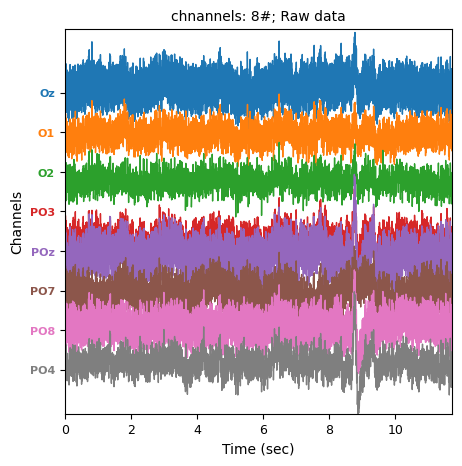

In [5]:
Plot_data.plot_data(data, fs, channels, first_point=0, last_point=3000, val_ylim=2.7, size_fig=(5,5), title='Raw data', 
                    display_figure="on")  # Plot EEG data using the Plot_data.plot_data function

**Step 1.3: Filtering**<br/>

*Input parameters:*
 - `data:` EEG data to be filtered
 - `f_low:` Lower cutoff frequency of the bandpass filter
 - `f_high:` Upper cutoff frequency of the bandpass filter
 - `order:` Filter order
 - `fs:` Sampling frequency of the EEG data (optional, if not provided, it is assumed to be fs)
 - `type_filter:` Type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'bandpass')

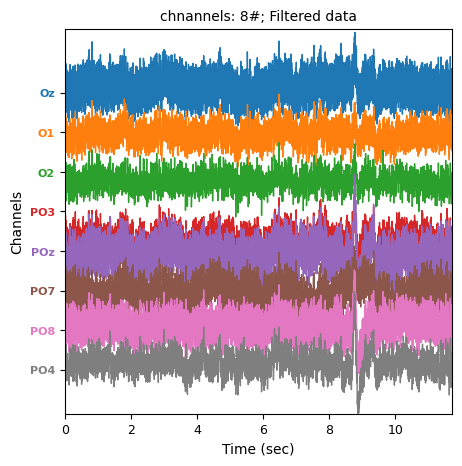

In [19]:
f_low, f_high, order = 0.05, 100, 3    # Define filter parameters
data_filtered = Filtering.filtering(data, f_low, f_high, order, fs=fs, type_filter='bandpass')# Apply bandpass filtering to the EEG data using the Filtering.filtering function
Plot_data.plot_data(data, fs, channels, first_point=0, last_point=3000, val_ylim=2.7, size_fig=(5,5), title='Filtered data', 
                    display_figure="on")

**Step 1.4: CAR filter**

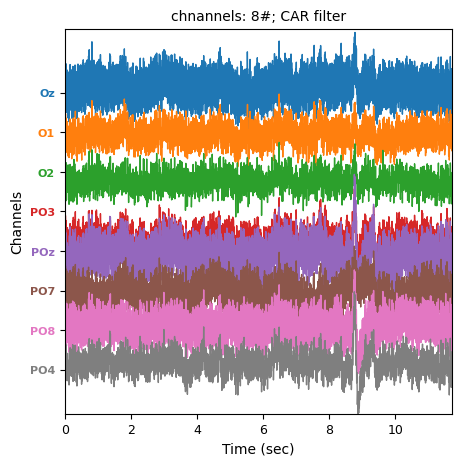

In [20]:
data_car = Common_average_reference.car(data_filtered) # Apply common average reference (CAR) to the EEG data using the Common_average_reference.car function
Plot_data.plot_data(data, fs, channels, first_point=0, last_point=3000, val_ylim=2.7, size_fig=(5,5), title='CAR filter', 
                    display_figure="on")

**Step 2: Split trials**

In [37]:
time_trial = 5                         # Define the duration of each trial in seconds
time_start_trial = events[:,0]         # Extract the start time of each trial from the events                   
duration_trial = int(fs * time_trial)  # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)

for i in range(3):                     # Loop through the labels of interest
    lab = ['33025', '33026', '33027']  # Define the labels for the current iteration
    num_trials = np.where(pos == lab[i])[0] # Find the indices of trials with the current label
    
    data_trial = np.zeros((duration_trial, len(channels), len(num_trials))) # Initialize an array to store trial data for the current label
    for j, trial_index in enumerate(num_trials): # Iterate over each trial index and extract the corresponding data
        data_trial[:, :, j] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
    exec(f'data_trial_{i + 1} = data_trial')    # Using exec to dynamically create variable names for each trial's data array

**Step 3: CCA Method**

In [9]:
x = data_trial_1[:,:,1]           # (number samples, number channel, number trials)
num_harmonic = 2                  # Number of harmonic for each frequency stimulation
num_channel = [1, 4]              # Number of Channel
f_stim = [13, 21, 17]             # Freqquencies stimuation
num_sample_neigh = 20             # Number of samples neighborhood for each frequency stimulation
num_samples_trial = int(fs * duration_trial)            
time = np.linspace(0, duration_trial, num_samples_trial)  # Time vector

f_low, f_high, order = 5, 50, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='bandstop') # Apply bandstop filtering to the EEG data 

f_high, order = min(f_stim) - 1, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='high') # Apply high filtering to the EEG data 

In [ ]:
from scipy.linalg import canoncorr
f_ref = np.zeros(len(f_stim))
for i in range(len(f_stim)):  # First loop for frequencies stimulation
    data_ref = np.zeros((len(time), 2 * num_harmonic))
    for j in range(num_harmonic):  # Second loop creates a reference signal for each frequency stimulation
        signal_ref = np.zeros((len(time), 2))
        signal_ref[:, 0] = np.sin(2 * np.pi * (j + 1) * f_stim[i] * time)
        signal_ref[:, 1] = np.cos(2 * np.pi * (j + 1) * f_stim[i] * time)
        data_ref[:, j * 2:(j + 1) * 2] = signal_ref
    _, _, a = canoncorr(data[:, num_channel], data_ref)
    f_ref[i] = np.max(a)
label_predic = np.argmax(f_ref)